In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import joblib

In [23]:
from tensorflow import keras
from keras.layers import Flatten, Dense

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

In [4]:
print(tf.__version__)

2.12.0


In [4]:
path = "datasets/Train"
archive = tf.keras.utils.get_file(os.path.abspath(path), origin='', extract=False)

data_dir = pathlib.Path(archive).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

15882


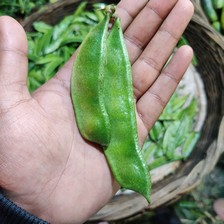

In [5]:
apples = list(data_dir.glob('Bean/*'))
PIL.Image.open(str(apples[100]))

In [83]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3072 files belonging to 28 classes.
Using 2458 files for training.


In [84]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3072 files belonging to 28 classes.
Using 614 files for validation.


In [45]:
class_names = train_ds.class_names
print(class_names)

['Bean', 'Beef', 'Beetroot', 'Bell Pepper', 'Broccoli', 'Cabbage', 'Carrot', 'Cauliflower', 'Cheese', 'Chicken', 'Cucumber', 'Egg', 'Eggplant', 'Flour', 'Garlic', 'Ginger Root', 'Lemon', 'Milk', 'Oil', 'Onion', 'Potato', 'Pumpkin', 'Radish', 'Rice', 'Sausage', 'Spaghetti', 'Toast Bread', 'Tomato']


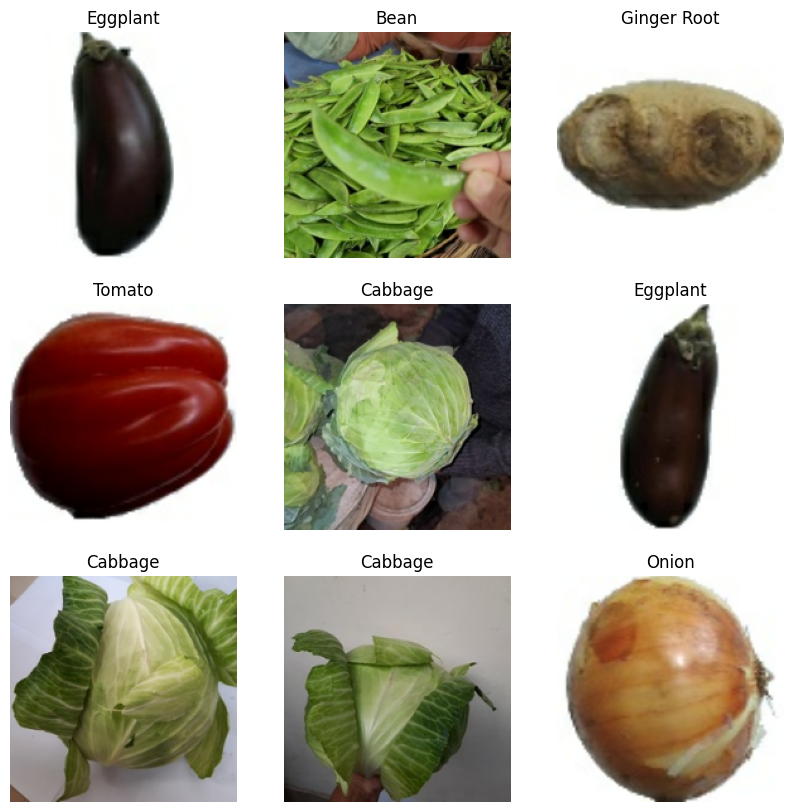

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in train_ds:
  image_batch.numpy()
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)


In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.14117704 1.0


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [16]:
num_classes = 73

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])



In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
1693/1693 [==============================] - 700s 413ms/step - loss: 0.3585 - accuracy: 0.9065 - val_loss: 0.0107 - val_accuracy: 0.9971
Epoch 2/3
1693/1693 [==============================] - 717s 424ms/step - loss: 0.0459 - accuracy: 0.9869 - val_loss: 0.0305 - val_accuracy: 0.9939
Epoch 3/3
1693/1693 [==============================] - 688s 407ms/step - loss: 0.0296 - accuracy: 0.9918 - val_loss: 0.0029 - val_accuracy: 0.9993


In [52]:
joblib.dump(class_names, "./class_names.joblib", compress=True)

['./class_names.joblib']

In [20]:
joblib.dump(model, "./custom-3Conv.joblib", compress=True)

['./custom-3Conv.joblib']

In [71]:
# Fixed ingredients classes
no_classes = 28

zoom_and_translate = keras.Sequential([
    keras.layers.RandomZoom(height_factor=[0, 1]),
    keras.layers.RandomTranslation( 
                                height_factor=[-0.5,0.5],
                                width_factor=[-0.5, 0.5])
])

data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.4),
])

input_t = keras.Input(shape=(180,180,3))

model = keras.Sequential()

resnet = keras.applications.ResNet50(include_top = False, weights = "imagenet")
model.add(input_t)
model.add(zoom_and_translate)
model.add(data_augmentation)
model.add(resnet)

for layer in model.layers[4:147]:
    layer.trainable = False
    
model.add(Flatten())
model.add(Dense(no_classes, activation = "softmax"))
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 sequential_26 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten_10 (Flatten)        (None, 73728)             0         
                                                                 
 dense_9 (Dense)             (None, 28)                2064412   
                                                                 
Total params: 25,652,124
Trainable params: 25,599,004
Non-trainable params: 53,120
_________________________________________________________________


In [72]:
model.compile(
  optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy'])

In [85]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
77/77 [==============================] - 355s 5s/step - loss: 0.1524 - accuracy: 0.9524 - val_loss: 0.1218 - val_accuracy: 0.9658
Epoch 2/10
77/77 [==============================] - 368s 5s/step - loss: 0.1480 - accuracy: 0.9532 - val_loss: 0.1008 - val_accuracy: 0.9691
Epoch 3/10
77/77 [==============================] - 379s 5s/step - loss: 0.1338 - accuracy: 0.9581 - val_loss: 0.1180 - val_accuracy: 0.9691
Epoch 4/10
77/77 [==============================] - 372s 5s/step - loss: 0.0976 - accuracy: 0.9691 - val_loss: 0.1169 - val_accuracy: 0.9674
Epoch 5/10
77/77 [==============================] - 351s 5s/step - loss: 0.0891 - accuracy: 0.9703 - val_loss: 0.1357 - val_accuracy: 0.9674
Epoch 6/10
77/77 [==============================] - 387s 5s/step - loss: 0.1031 - accuracy: 0.9687 - val_loss: 0.1416 - val_accuracy: 0.9723
Epoch 7/10
77/77 [==============================] - 370s 5s/step - loss: 0.0952 - accuracy: 0.9719 - val_loss: 0.1454 - val_accuracy: 0.9739
Epoch 8/10
77

In [86]:
joblib.dump(model, "./custom-resnet.joblib", compress=True)

['./custom-resnet.joblib']